Aim: predict age and gender from RFIW2021 data -- train and val sets.

1. Inspect MiVOLO to understand its setup
2. Copy the necessary code
3. Adapt it to save each prediction to a dataframe (maybe extending val.txt to have age and gender)
4. Analyse the generated dataframe

## Import libraries

In [1]:
from dataclasses import dataclass
from pathlib import Path

import cv2
import pandas as pd
from mivolo.data.data_reader import get_all_files
from mivolo.predictor import Predictor
from tqdm import tqdm

# Set up paths

In [2]:
try:
    IS_NOTEBOOK = True
    HERE = Path(__file__).resolve().parent
except NameError:
    IS_NOTEBOOK = False
    HERE = Path().resolve()

DATA_DIR = Path(HERE, "../rfiw2021/Track1/Validation/val-faces")
MODELS_DIR = Path(HERE, "../MiVOLO/models")

In [3]:
@dataclass
class Config:
    device: str = "cuda"
    detector_weights: str = MODELS_DIR / "yolov8x_person_face.pt"
    checkpoint: str = MODELS_DIR / "mivolo_imbd.pth.tar"
    with_persons: bool = False
    disable_faces: bool = False
    draw = False

In [4]:
args = Config()
predictor = Predictor(args)

Model summary (fused): 268 layers, 68125494 parameters, 0 gradients


In [5]:
image_files = get_all_files(DATA_DIR)

preds = []
errors = []

for img_p in tqdm(image_files):
    img = cv2.imread(img_p)
    try:
        pred, out_im = predictor.recognize(img)
        pred_info = {"age": pred.ages[1], "gender": pred.genders[1], "gender_score": pred.gender_scores[1]}
    except:
        errors.append(img_p)
        pred_info = {"age": 0, "gender": "U", "gender_score": 0}
    img_info = {k: v for k, v in zip(["fid", "mid", "pid_filename"], Path(img_p).parts[-3:])}
    preds.append({**img_info, **pred_info})

print(f"Errors found: {len(errors)}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5045/5045 [03:08<00:00, 26.79it/s]

Errors found: 162


In [6]:
errors[:10]

['/warley/dev/research/kinship/notebooks/../rfiw2021/Track1/Validation/val-faces/F0547/MID4/P05737_face0.jpg',
 '/warley/dev/research/kinship/notebooks/../rfiw2021/Track1/Validation/val-faces/F0547/MID1/P05736_face0.jpg',
 '/warley/dev/research/kinship/notebooks/../rfiw2021/Track1/Validation/val-faces/F0505/MID2/P05338_face1.jpg',
 '/warley/dev/research/kinship/notebooks/../rfiw2021/Track1/Validation/val-faces/F0705/MID2/P07370_face1.jpg',
 '/warley/dev/research/kinship/notebooks/../rfiw2021/Track1/Validation/val-faces/F0705/MID1/P07378_face0.jpg',
 '/warley/dev/research/kinship/notebooks/../rfiw2021/Track1/Validation/val-faces/F0063/MID3/P00637_face0.jpg',
 '/warley/dev/research/kinship/notebooks/../rfiw2021/Track1/Validation/val-faces/F0063/MID1/P00637_face2.jpg',
 '/warley/dev/research/kinship/notebooks/../rfiw2021/Track1/Validation/val-faces/F0063/MID1/P00636_face0.jpg',
 '/warley/dev/research/kinship/notebooks/../rfiw2021/Track1/Validation/val-faces/F0324/MID1/P03439_face1.jpg',
 

In [7]:
preds[:5]

[{'fid': 'F0119',
  'mid': 'MID2',
  'pid_filename': 'P01237_face3.jpg',
  'age': 19.8,
  'gender': 'female',
  'gender_score': 0.99755859375},
 {'fid': 'F0119',
  'mid': 'MID2',
  'pid_filename': 'P01243_face1.jpg',
  'age': 18.37,
  'gender': 'female',
  'gender_score': 0.9970703125},
 {'fid': 'F0119',
  'mid': 'MID2',
  'pid_filename': 'P01236_face0.jpg',
  'age': 20.42,
  'gender': 'female',
  'gender_score': 0.99755859375},
 {'fid': 'F0119',
  'mid': 'MID2',
  'pid_filename': 'P01240_face2.jpg',
  'age': 26.59,
  'gender': 'female',
  'gender_score': 0.9970703125},
 {'fid': 'F0119',
  'mid': 'MID2',
  'pid_filename': 'P01239_face3.jpg',
  'age': 23.44,
  'gender': 'female',
  'gender_score': 0.9970703125}]

In [8]:
ag_preds = pd.DataFrame(preds)

In [9]:
ag_preds

,fid,mid,pid_filename,age,gender,gender_score
0,F0119,MID2,P01237_face3.jpg,19.80,female,0.997559
1,F0119,MID2,P01243_face1.jpg,18.37,female,0.997070
2,F0119,MID2,P01236_face0.jpg,20.42,female,0.997559
3,F0119,MID2,P01240_face2.jpg,26.59,female,0.997070
4,F0119,MID2,P01239_face3.jpg,23.44,female,0.997070
...,...,...,...,...,...,...
5040,F0446,MID1,P04720_face2.jpg,NaN,None,NaN
5041,F0446,MID1,P04721_face3.jpg,57.97,male,0.997559
5042,F0446,MID1,P04712_face4.jpg,0.00,U,0.000000
5043,F0446,MID1,P04719_face0.jpg,54.56,male,0.997559


In [10]:
ag_preds.fillna(0, inplace=True)
ag_preds.replace({None: 'unknown'}, inplace=True)
ag_preds

,fid,mid,pid_filename,age,gender,gender_score
0,F0119,MID2,P01237_face3.jpg,19.80,female,0.997559
1,F0119,MID2,P01243_face1.jpg,18.37,female,0.997070
2,F0119,MID2,P01236_face0.jpg,20.42,female,0.997559
3,F0119,MID2,P01240_face2.jpg,26.59,female,0.997070
4,F0119,MID2,P01239_face3.jpg,23.44,female,0.997070
...,...,...,...,...,...,...
5040,F0446,MID1,P04720_face2.jpg,0.00,0,0.000000
5041,F0446,MID1,P04721_face3.jpg,57.97,male,0.997559
5042,F0446,MID1,P04712_face4.jpg,0.00,U,0.000000
5043,F0446,MID1,P04719_face0.jpg,54.56,male,0.997559


# Data Analysis

- Age histogram for each kinship relation, for each face image
- Gender histogram for each kinship relation, for each face index

We are supposing that there are no intersections between faces in the pairs. That is, first faces aren't present as second faces in any other pair.

What I found while coding:

1. Face pairs with repeated faces are possible for face 1.

## Steps

1. Load validation pairs info into a dataframe: `val_pairs`
2. Extract FID, MID, filename to new columns
3. Merge age and gender predictions `ag_preds` with `val_pairs`
   - New dataframe will have: `face1_path, face2_path, kin_relation, is_kin, face1_family_id (fid1), face2_family_id (fid2), pid1_age, pid1_gender, pid2_age, pid2_gender`
4. Plot histograms: a unique plot with 2 subplots, where row 1 has age and row 2 has gender for both faces histogram densitys overlaid

In [11]:
def load_data(path: str):
    df = pd.read_csv(path, 
                     delimiter=" ",  header=None, 
                     names=["id", "face1_path", "face2_path", "kin_relation", "is_kin"],
                    )
    df.drop(["id"], inplace=True, axis=1)
    return df
    
val_pairs_fp = Path(HERE, "../rfiw2021/Track1/sample0/val.txt")
val_pairs_fp_model_sel = Path(HERE, "../rfiw2021/Track1/sample0/val_choose.txt")
val_pairs1 = load_data(val_pairs_fp)
val_pairs2 = load_data(val_pairs_fp_model_sel)
val_pairs = pd.concat([val_pairs1, val_pairs2]).reset_index(drop=True)
val_pairs

,face1_path,face2_path,kin_relation,is_kin
0,Validation/val-faces/F0007/MID1/P00075_face0.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1
1,Validation/val-faces/F0007/MID1/P00078_face3.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1
2,Validation/val-faces/F0007/MID1/P11275_face2.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1
3,Validation/val-faces/F0007/MID1/P00077_face12.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1
4,Validation/val-faces/F0007/MID1/P00082_face1.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1
...,...,...,...,...
105557,Validation/val-faces/F0422/MID1/P04458_face2.jpg,Validation/val-faces/F0422/MID3/P04453_face1.jpg,bb,1
105558,Validation/val-faces/F0990/MID5/P10431_face0.jpg,Validation/val-faces/F0990/MID9/P10435_face4.jpg,md,1
105559,Validation/val-faces/F0205/MID4/P02198_face1.jpg,Validation/val-faces/F0205/MID7/P02196_face1.jpg,fd,1
105560,Validation/val-faces/F0133/MID1/P01399_face1.jpg,Validation/val-faces/F0133/MID3/P09125_face1.jpg,fs,1


In [12]:
# Processing face1_path
face1_parts = val_pairs.face1_path.apply(lambda x: Path(x).parts[-3:])
val_pairs[['f1fid', 'f1mid', 'f1fp']] = pd.DataFrame(face1_parts.tolist())

# Processing face2_path
face2_parts = val_pairs.face2_path.apply(lambda x: Path(x).parts[-3:])
val_pairs[['f2fid', 'f2mid', 'f2fp']] = pd.DataFrame(face2_parts.tolist())
val_pairs

,face1_path,face2_path,kin_relation,is_kin,f1fid,f1mid,f1fp,f2fid,f2mid,f2fp
0,Validation/val-faces/F0007/MID1/P00075_face0.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1,F0007,MID1,P00075_face0.jpg,F0007,MID9,P00079_face3.jpg
1,Validation/val-faces/F0007/MID1/P00078_face3.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1,F0007,MID1,P00078_face3.jpg,F0007,MID9,P00079_face3.jpg
2,Validation/val-faces/F0007/MID1/P11275_face2.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1,F0007,MID1,P11275_face2.jpg,F0007,MID9,P00079_face3.jpg
3,Validation/val-faces/F0007/MID1/P00077_face12.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1,F0007,MID1,P00077_face12.jpg,F0007,MID9,P00079_face3.jpg
4,Validation/val-faces/F0007/MID1/P00082_face1.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1,F0007,MID1,P00082_face1.jpg,F0007,MID9,P00079_face3.jpg
...,...,...,...,...,...,...,...,...,...,...
105557,Validation/val-faces/F0422/MID1/P04458_face2.jpg,Validation/val-faces/F0422/MID3/P04453_face1.jpg,bb,1,F0422,MID1,P04458_face2.jpg,F0422,MID3,P04453_face1.jpg
105558,Validation/val-faces/F0990/MID5/P10431_face0.jpg,Validation/val-faces/F0990/MID9/P10435_face4.jpg,md,1,F0990,MID5,P10431_face0.jpg,F0990,MID9,P10435_face4.jpg
105559,Validation/val-faces/F0205/MID4/P02198_face1.jpg,Validation/val-faces/F0205/MID7/P02196_face1.jpg,fd,1,F0205,MID4,P02198_face1.jpg,F0205,MID7,P02196_face1.jpg
105560,Validation/val-faces/F0133/MID1/P01399_face1.jpg,Validation/val-faces/F0133/MID3/P09125_face1.jpg,fs,1,F0133,MID1,P01399_face1.jpg,F0133,MID3,P09125_face1.jpg


In [13]:
ag_preds

,fid,mid,pid_filename,age,gender,gender_score
0,F0119,MID2,P01237_face3.jpg,19.80,female,0.997559
1,F0119,MID2,P01243_face1.jpg,18.37,female,0.997070
2,F0119,MID2,P01236_face0.jpg,20.42,female,0.997559
3,F0119,MID2,P01240_face2.jpg,26.59,female,0.997070
4,F0119,MID2,P01239_face3.jpg,23.44,female,0.997070
...,...,...,...,...,...,...
5040,F0446,MID1,P04720_face2.jpg,0.00,0,0.000000
5041,F0446,MID1,P04721_face3.jpg,57.97,male,0.997559
5042,F0446,MID1,P04712_face4.jpg,0.00,U,0.000000
5043,F0446,MID1,P04719_face0.jpg,54.56,male,0.997559


In [14]:
val_pairs = val_pairs.merge(ag_preds, left_on=['f1fid', 'f1mid', 'f1fp'], right_on=['fid', 'mid', 'pid_filename'], how='inner')
val_pairs.rename(columns={'age': 'f1_age', 'gender': 'f1_gender', 'gender_score': 'f1_gender_score'}, inplace=True)
val_pairs.drop(['fid', 'mid', 'pid_filename'], axis=1, inplace=True)
val_pairs = val_pairs.merge(ag_preds, left_on=['f2fid', 'f2mid', 'f2fp'], right_on=['fid', 'mid', 'pid_filename'], how='inner')
val_pairs.rename(columns={'age': 'f2_age', 'gender': 'f2_gender', 'gender_score': 'f2_gender_score'}, inplace=True)
val_pairs.drop(['fid', 'mid', 'pid_filename'], axis=1, inplace=True)
val_pairs

,face1_path,face2_path,kin_relation,is_kin,f1fid,f1mid,f1fp,f2fid,f2mid,f2fp,f1_age,f1_gender,f1_gender_score,f2_age,f2_gender,f2_gender_score
0,Validation/val-faces/F0007/MID1/P00075_face0.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1,F0007,MID1,P00075_face0.jpg,F0007,MID9,P00079_face3.jpg,0.00,U,0.00000,11.28,male,0.558594
1,Validation/val-faces/F0007/MID1/P00078_face3.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1,F0007,MID1,P00078_face3.jpg,F0007,MID9,P00079_face3.jpg,54.70,male,0.99707,11.28,male,0.558594
2,Validation/val-faces/F0007/MID1/P11275_face2.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1,F0007,MID1,P11275_face2.jpg,F0007,MID9,P00079_face3.jpg,28.54,male,0.99707,11.28,male,0.558594
3,Validation/val-faces/F0007/MID1/P11275_face2.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1,F0007,MID1,P11275_face2.jpg,F0007,MID9,P00079_face3.jpg,28.54,male,0.99707,11.28,male,0.558594
4,Validation/val-faces/F0007/MID1/P00077_face12.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1,F0007,MID1,P00077_face12.jpg,F0007,MID9,P00079_face3.jpg,0.00,U,0.00000,11.28,male,0.558594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105557,Validation/val-faces/F0986/MID8/P10390_face2.jpg,Validation/val-faces/F0986/MID1/P10390_face5.jpg,ms,1,F0986,MID8,P10390_face2.jpg,F0986,MID1,P10390_face5.jpg,60.59,female,0.99707,33.00,male,0.997070
105558,Validation/val-faces/F0986/MID8/P10391_face0.jpg,Validation/val-faces/F0986/MID1/P10390_face5.jpg,ms,1,F0986,MID8,P10391_face0.jpg,F0986,MID1,P10390_face5.jpg,48.21,female,0.99707,33.00,male,0.997070
105559,Validation/val-faces/F0986/MID8/P10388_face2.jpg,Validation/val-faces/F0986/MID1/P10390_face5.jpg,ms,1,F0986,MID8,P10388_face2.jpg,F0986,MID1,P10390_face5.jpg,38.85,female,0.99707,33.00,male,0.997070
105560,Validation/val-faces/F0986/MID8/P10383_face5.jpg,Validation/val-faces/F0986/MID1/P10390_face5.jpg,ms,1,F0986,MID8,P10383_face5.jpg,F0986,MID1,P10390_face5.jpg,52.72,female,0.99707,33.00,male,0.997070


In [15]:
val_pairs.dtypes

face1_path          object
face2_path          object
kin_relation        object
is_kin               int64
f1fid               object
f1mid               object
f1fp                object
f2fid               object
f2mid               object
f2fp                object
f1_age             float64
f1_gender           object
f1_gender_score    float64
f2_age             float64
f2_gender           object
f2_gender_score    float64
dtype: object

## Plot histograms

/home/warley/.virtualenvs/mivolo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/warley/.virtualenvs/mivolo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


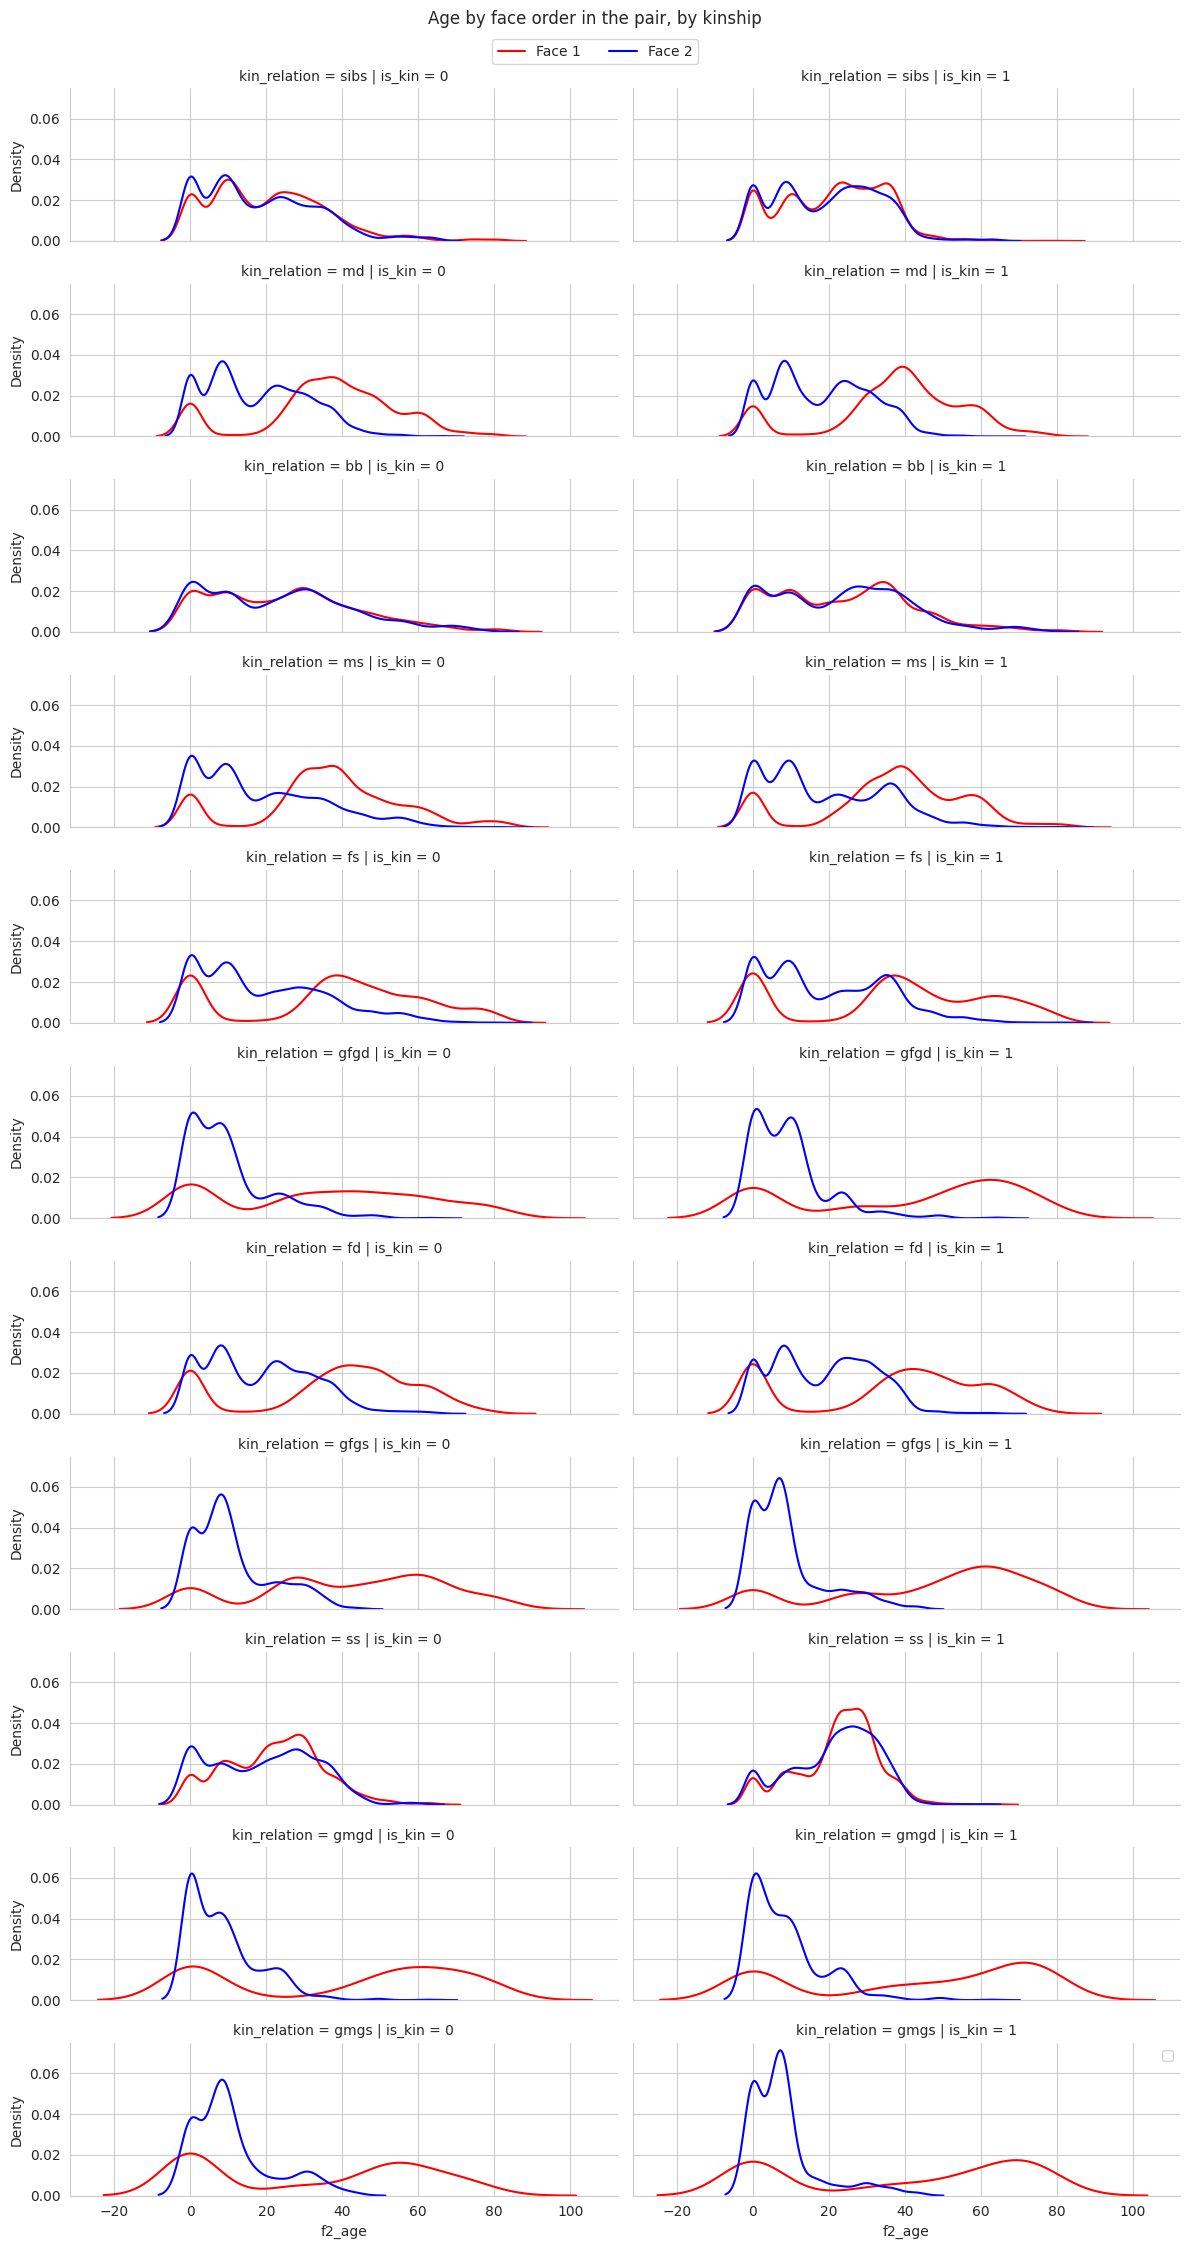

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

sns.set_style('whitegrid')

g = sns.FacetGrid(val_pairs, col='is_kin', row='kin_relation', height=2, aspect=3)
g = g.map(sns.kdeplot, 'f1_age', color='red')
g = g.map(sns.kdeplot, 'f2_age', color='blue')

# Create custom lines for the legend
red_line = mlines.Line2D([], [], color='red', label='Face 1')
blue_line = mlines.Line2D([], [], color='blue', label='Face 2')

# Adding the legend at the top
g.fig.legend(handles=[red_line, blue_line], loc='upper center', bbox_to_anchor=[0.5, 1.01], ncol=2)

plt.suptitle('Age by face order in the pair, by kinship', y=1.02)
plt.legend()
plt.show()